# Assignment 01

- Name: Ran Arino
- Student ID: 153073200
- Email: rarino@myseneca.ca
- Course: Machine Learning
- Course ID: BDA500NAA.05380.2237
- Professor: Dr. Amir Moslemi

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# 1. Data Preparation & Observation

In [2]:
# 1-1: load dataset

col_names = ['age', 'year', 'axillary', 'survival']
df = pd.read_csv('haberman.csv', header=None, names=col_names)
df.head()

,age,year,axillary,survival
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1


In [3]:
# 1-2: check meta data and missing values

# dimention
print("Dimenison: ", df.shape)
print('')
# dtypes
print('Data Types:')
print(df.dtypes)
print('')
# missing data 
print('Missing Data: ')
print(df.isna().sum())

Dimenison:  (306, 4)

Data Types:
age         int64
year        int64
axillary    int64
survival    int64
dtype: object

Missing Data: 
age         0
year        0
axillary    0
survival    0
dtype: int64


In [4]:
# 1-3: change target label

df['survival'] = df['survival'].map({1: 1, 2: 0})
print(df['survival'].value_counts())

survival
1    225
0     81
Name: count, dtype: int64


In [5]:
# 1-4: fundamental statistics
df.describe()

,age,year,axillary,survival
count,306.000000,306.000000,306.000000,306.000000
mean,52.457516,62.852941,4.026144,0.735294
std,10.803452,3.249405,7.189654,0.441899
min,30.000000,58.000000,0.000000,0.000000
25%,44.000000,60.000000,0.000000,0.000000
50%,52.000000,63.000000,1.000000,1.000000
75%,60.750000,65.750000,4.000000,1.000000
max,83.000000,69.000000,52.000000,1.000000


In [6]:
# 1-4 Cont.: removing an outlier 
df = df[df['axillary'] != 52]
print("New dimention: ", df.shape)

New dimention:  (305, 4)


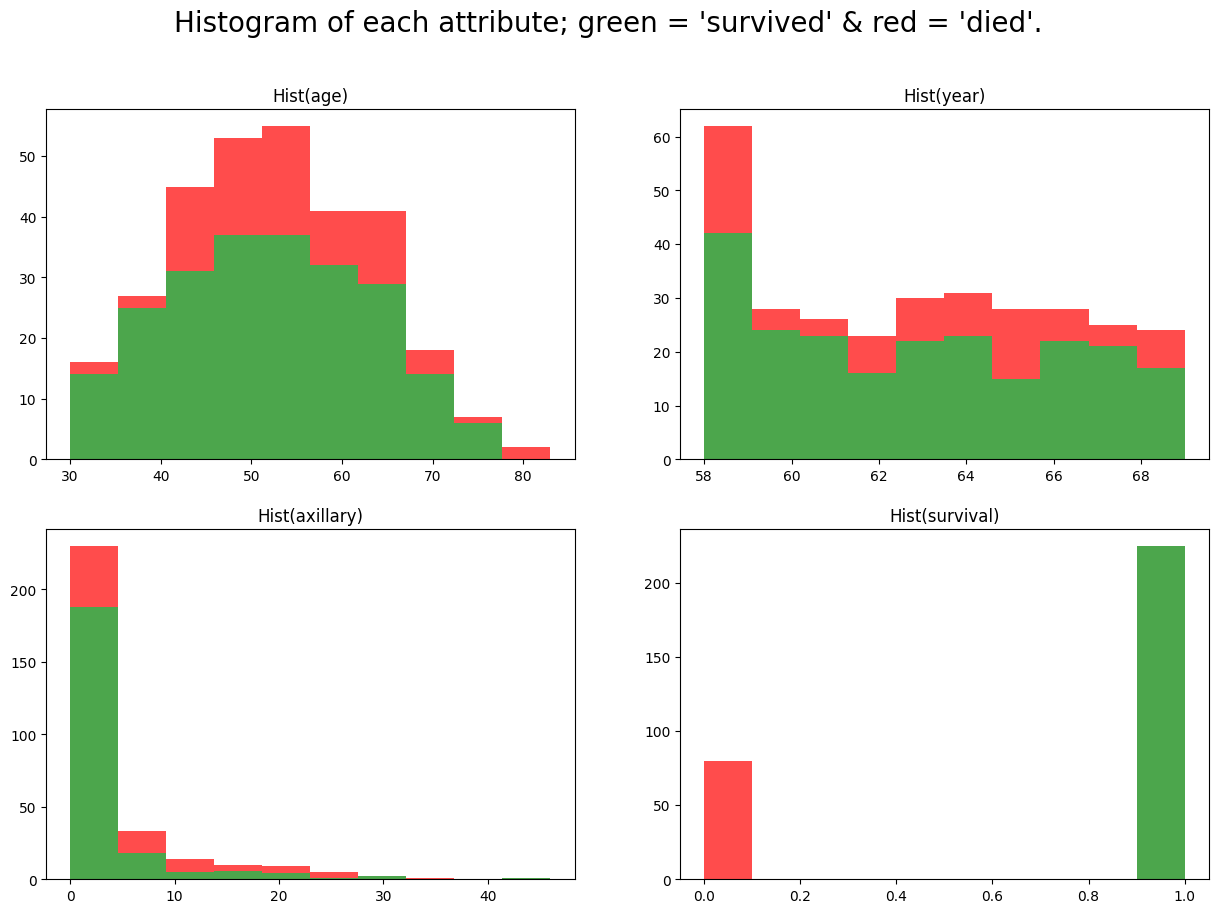

In [7]:
# 1-5: histogram for each data
R, C = 2, 2
fig, ax = plt.subplots(nrows=R, ncols=C, figsize=(15, 10))


for i, col in enumerate(df.columns):
    x, y = i // R, i % C
    data_survived = df[df['survival'] == 1][col]
    data_died = df[df['survival'] == 0][col]

    ax[x][y].hist([data_survived, data_died], color=['green', 'red'], alpha=0.7, stacked=True)
    ax[x][y].set_title(f'Hist({col})')

fig.suptitle("Histogram of each attribute; green = 'survived' & red = 'died'.", size=20)
plt.show()

# 2. Model Creation

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [37]:
# 2-1: splitting dataset

X = np.array(df[['axillary', 'age', 'year']])
y = np.array(df['survival'])

# scale changes
scaler = StandardScaler()
X_ss = scaler.fit_transform(X)

# train-test splitting
X_train, X_test, y_train, y_test = train_test_split(X_ss, y, test_size=0.3, random_state=42)

print(f'Train -> x: {len(X_train)}, y: {len(y_train)}')
print(f'Test -> x: {len(X_test)}, y: {len(y_test)}')

Train -> x: 213, y: 213
Test -> x: 92, y: 92


In [38]:
# 2-2: apply logistic regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
yhat_log_reg = log_reg.predict(X_test)
cm_log_reg = confusion_matrix(y_test, yhat_log_reg)
cm_log_reg

array([[ 6, 17],
       [ 8, 61]], dtype=int64)

In [45]:
# 2-3: apply Linear SVM model

# find the best parameter "C"
gridsearchCV = GridSearchCV(LinearSVC(dual='auto'), {'C': [0.1, 1, 10, 100]}, cv=5)
grid_search = gridsearchCV.fit(X_ss, y)
best_C = grid_search.best_estimator_.C
print('Best C: ', best_C)

# fit model on training data based on the best parameter 
lr_svm = LinearSVC(C=best_C, loss='hinge', dual='auto')
lr_svm.fit(X_train, y_train)
yhat_lr_svm = lr_svm.predict(X_test)
cm_lr_svm = confusion_matrix(y_test, yhat_lr_svm)
cm_lr_svm

Best C:  0.1


array([[ 6, 17],
       [ 9, 60]], dtype=int64)

In [46]:
# 2-4 apply SVM model with polynomial kernel trick

# find the best hyperparameters; coef0 and C
gridsearchCV = GridSearchCV(SVC(kernel='poly', degree=2), 
                            {'coef0': [0.1, 1, 10, 100], 'C': [0.1, 1, 10, 100]}, 
                            cv=5)
grid_search = gridsearchCV.fit(X_ss, y)
best_coef0 = grid_search.best_estimator_.coef0
best_C = grid_search.best_estimator_.C
print(f'Best coef0: {best_coef0}, \nBest C: {best_C}')

# set classifier
poly_kernel_svm = SVC(kernel='poly', degree=2, coef0=best_coef0, C=best_C)
poly_kernel_svm.fit(X_train, y_train)
yhat_poly_svm = poly_kernel_svm.predict(X_test)
cm_poly_svm = confusion_matrix(y_test, yhat_poly_svm)
cm_poly_svm

Best coef0: 0.1, 
Best C: 10


array([[ 6, 17],
       [10, 59]], dtype=int64)

# Model Evaluations

In [58]:
# 3-1: Score data frame

# create the confusion matrix of each model
cm_dict = {'LR': cm_log_reg, 'LSVM': cm_lr_svm, "PSVM": cm_poly_svm}
# define names of three models abd four measures
models = list(cm_dict.keys())
measures = ['accuracy', 'recall', 'precision', 'f1']


# calculate accuracy, precision, recall and f1 score for each model
scores = []
for key in cm_dict.keys():
    cm = cm_dict[key]
    accuracy = np.trace(cm) / np.sum(cm)
    recall = cm[1, 1] / np.sum(cm[1, :])
    precision = cm[1,1] / np.sum(cm[:, 1])
    f1 = 2 * (precision*recall) / (precision + recall)
    scores.extend([accuracy, recall, precision, f1])
    
# define data frame for all score
score_df = pd.DataFrame(
    {'model': np.repeat(models, len(measures)),
    'measure': np.tile(measures, len(models)),
    'score': scores
    })

score_df

,model,measure,score
0,LR,accuracy,0.728261
1,LR,recall,0.884058
2,LR,precision,0.782051
3,LR,f1,0.829932
4,LSVM,accuracy,0.717391
5,LSVM,recall,0.869565
6,LSVM,precision,0.779221
7,LSVM,f1,0.821918
8,PSVM,accuracy,0.706522
9,PSVM,recall,0.855072


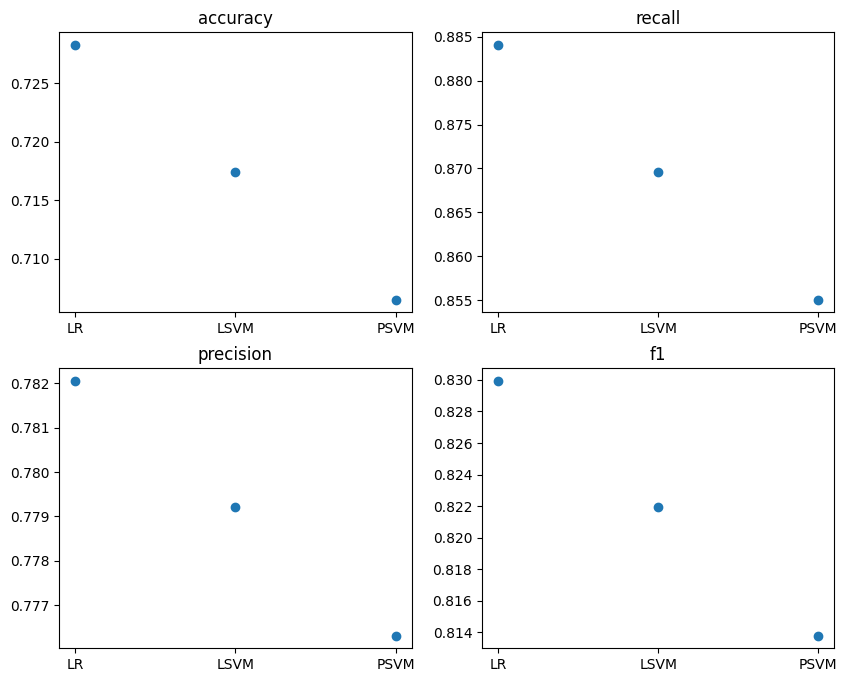

In [66]:
# show visualization
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

for i, ms in enumerate(measures):
    r, c = i // 2, i % 2
    # df for each measure
    part_df = score_df[score_df['measure'] == ms]
    
    ax[r][c].scatter(x=part_df['model'], y=part_df['score'])
    ax[r][c].set_title(f'{ms}')